In [1]:
import os

os.environ['backend'] = "pytorch"
import psfit
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from psfit import Linear
from psfit.data import DataLoader, MNIST, ImageNormalizer
from psfit.module import SoftmaxLoss
from psfit.optim import LocalTrainer, SGD, ProjectionSparsifier, L1, L2
from psfit.optim.optimizer import Admm

In [2]:
backend = psfit.get_backend()
print(f"Backend name: {backend.name}")
print(f"Backend type: {backend}")

Backend name: PyTorch
Backend type: backend(dev=cuda, api=pytorch)


In [3]:
ds = MNIST("../data/mnist-data.npz", cv = True, cv_size = 0.1, preprocessor = ImageNormalizer())
loader = DataLoader(dataset = ds, batch_size = len(ds) // 2, shuffle = True, report = True)

Loading batches to cuda

Number of batches loaded: 2


In [4]:
print("dataset:", ds)

dataset: MNIST()


In [5]:
x_cv, y_cv = ds.cv_data
x_tr, y_tr = ds.train_data

In [6]:
n, c = ds.number_of_features, ds.number_of_classes
model = Linear(in_features = n, out_features = c)

In [7]:
trainer = LocalTrainer(
    dataloader = loader,
    loss = SoftmaxLoss(),
    optimizer = SGD(model, learning_rate = 0.4),
    verbose = False
)


def predict(x):
    logits = x @ model.parameters.array().cpu().numpy()
    predictions = np.argmax(logits, axis = 1, keepdims = True)
    return predictions

In [8]:
penalty = 1
l0_reg = ProjectionSparsifier(density = 100)
l1_reg = L1(admm_penalty = penalty, l1_penalty = 0.001)
l2_reg = L2(admm_penalty = penalty, l2_penalty = 0.005)



In [9]:

regularizers = {
    "L0": [l0_reg],
    "Lasso": [l1_reg],
    "Ridge": [l2_reg],
    "Elastic Net": [l2_reg, l1_reg],
}

loss_values = {
    "L0": [],
    "Lasso": [],
    "Ridge": [],
    "Elastic Net": [],

}

primal_error_values = {
    "L0": [],
    "Lasso": [],
    "Ridge": [],
    "Elastic Net": [],
}
train_accuracy = {
    "L0": [],
    "Lasso": [],
    "Ridge": [],
    "Elastic Net": [],

}
validation_accuracy = {
    "L0": [],
    "Lasso": [],
    "Ridge": [],
    "Elastic Net": [],

}
weights = {
    "L0": None,
    "Lasso": None,
    "Ridge": None,
    "Elastic Net": None,
}

iters = 600
epoch = 0

for reg_name, aggregators in regularizers.items():
    print(f"Training with {reg_name}")

    model.init_params()

    optimizer = Admm(trainer = trainer, aggregators = aggregators)

    for epoch in range(iters):

        loss, err = optimizer.step(penalty = penalty)
        loss_values[reg_name].append(loss)

        pred_training = predict(x_tr)
        pred_validation = predict(x_cv)

        train_acc = accuracy_score(y_tr, pred_training)
        cv_acc = accuracy_score(y_cv, pred_validation)

        train_accuracy[reg_name].append(train_acc)
        validation_accuracy[reg_name].append(cv_acc)
        primal_error_values[reg_name].append(err)

        weights[reg_name] = model.parameters

        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch + 1:3d}: Loss = {loss:.4f}, Error = {err:.6f}, Training = {train_acc:.6f}, Validation = {cv_acc:.6f}, Model: {reg_name}")
    print()

Training with L0


/home/alirezaolama/projects/PsFIT/psfit/autodiff.py:323: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  value = value.array().T


Epoch 100: Loss = 0.4610, Error = 0.000022, Training = 0.865852, Validation = 0.866333, Model: L0
Epoch 200: Loss = 0.4231, Error = 0.000000, Training = 0.877833, Validation = 0.878500, Model: L0
Epoch 300: Loss = 0.4016, Error = 0.000000, Training = 0.885519, Validation = 0.884000, Model: L0
Epoch 400: Loss = 0.3881, Error = 0.000000, Training = 0.889333, Validation = 0.887000, Model: L0
Epoch 500: Loss = 0.3779, Error = 0.000000, Training = 0.892481, Validation = 0.890833, Model: L0
Epoch 600: Loss = 0.3700, Error = 0.000000, Training = 0.894722, Validation = 0.891500, Model: L0

Training with Lasso
Epoch 100: Loss = 0.4241, Error = 0.000001, Training = 0.889704, Validation = 0.888833, Model: Lasso
Epoch 200: Loss = 0.4062, Error = 0.000000, Training = 0.894037, Validation = 0.892500, Model: Lasso
Epoch 300: Loss = 0.3999, Error = 0.000000, Training = 0.895926, Validation = 0.894000, Model: Lasso
Epoch 400: Loss = 0.3968, Error = 0.000000, Training = 0.896907, Validation = 0.894167, 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 2.5))
epochs = list(range(iters))

colors = ['#d62728', '#9467bd', '#1f77b4', '#ff7f0e', '#2ca02c',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'D']

i = 0
for model_name, loss_value in loss_values.items():
    ax1.plot(epochs, loss_value, linestyle = '-', color = colors[i], marker = markers[i], markersize = 4,
             label = model_name, markevery = 20)
    ax1.set_xlabel('Epochs', fontsize = 12)
    ax1.set_ylabel('Loss', fontsize = 12)
    ax1.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
    ax1.legend()
    i += 1

i = 0
for model_name, primal_error in primal_error_values.items():
    ax2.plot(epochs, primal_error, linestyle = '-', color = colors[i], marker = markers[i], markersize = 4,
             label = model_name, markevery = 20)
    ax2.set_xlabel('Epochs', fontsize = 12)
    ax2.set_ylabel('Error', fontsize = 12)
    ax2.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
    ax2.legend()
    i += 1

plt.xlabel('Epochs', fontsize = 12)  # X-axis label
plt.ylabel('Loss', fontsize = 12)  # Y-axis label

# Add a grid for better readability
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 2.5))
i = 0
for model_name, train_acc in train_accuracy.items():
    ax1.plot(epochs, train_acc, linestyle = '-', color = colors[i], marker = markers[i], markersize = 4,
             label = model_name, markevery = 20)
    ax1.set_xlabel('Epochs', fontsize = 12)
    ax1.set_ylabel('Training Accuracy', fontsize = 12)
    ax1.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
    ax1.legend()
    i += 1

i = 0
for model_name, validation_acc in validation_accuracy.items():
    ax2.plot(epochs, validation_acc, linestyle = '-', color = colors[i], marker = markers[i], markersize = 4,
             label = model_name, markevery = 20)
    ax2.set_xlabel('Epochs', fontsize = 12)
    ax2.set_ylabel('Validation Accuracy', fontsize = 12)
    ax2.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
    ax2.legend()
    i += 1
plt.tight_layout()
plt.savefig(f"../figures/training_validation_{ds.__class__.__name__.lower()}.pdf",
            dpi = 300)


In [ ]:
models = [key for key in weights.keys()]
sparsity = [len(np.nonzero(weights[k].array()[:, 0])[0]) for k in weights.keys()]
sparsity

In [ ]:

# Create the bar plot
plt.figure(figsize = (6, 5))
bars = plt.bar(models, sparsity, color = 'skyblue', edgecolor = 'black', width = 0.5, )

plt.xlabel('Models', fontsize = 12)
plt.ylabel('Non-zero Weights Count', fontsize = 12)

# Add values on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha = 'center', va = 'bottom', fontsize = 10, fontweight = 'bold')

# Customize ticks and layout for better presentation
plt.xticks(rotation = 45, ha = 'right', fontsize = 12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
digit = 5
size = (28, 28)
w_l0 = weights['L0'].array()[:, digit]
w_l1 = weights['Lasso'].array()[:, digit]
w_l12 = weights['Elastic Net'].array()[:, digit]
w_r = weights['Ridge'].array()[:, digit]

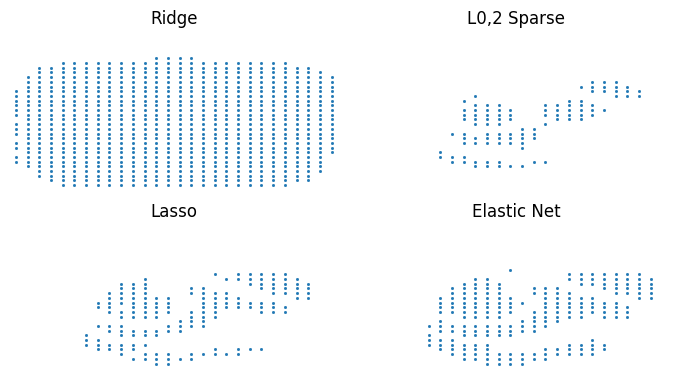

In [91]:

fig, ax = plt.subplots(2, 2, figsize = (7, 4))
ax[0, 0].spy(w_r.reshape(size), aspect = 'auto', markersize = 1)
ax[0, 0].set_title("Ridge")
ax[0, 0].axis('off')

ax[0, 1].spy(w_l0.reshape(size), aspect = 'auto', markersize = 1)
ax[0, 1].set_title("L0")
ax[0, 1].axis('off')

ax[1, 0].spy(w_l1.reshape(size), aspect = 'auto', markersize = 1)
ax[1, 0].set_title("Lasso")
ax[1, 0].axis('off')

ax[1, 1].spy(w_l12.reshape(size), aspect = 'auto', markersize = 1)
ax[1, 1].set_title("Elastic Net")
ax[1, 1].axis('off')
plt.tight_layout()

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

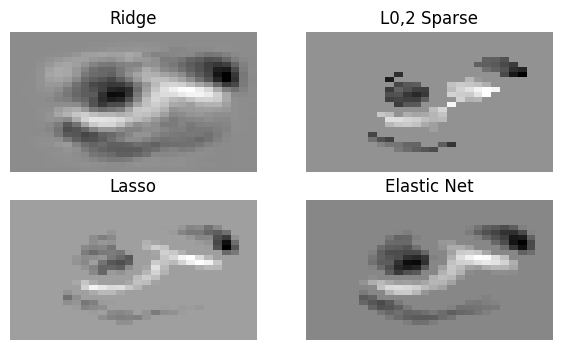

In [92]:
fig, ax = plt.subplots(2, 2, figsize = (7, 4))

ax[0, 0].imshow(w_r.reshape(size), aspect = 'auto', cmap = "binary")
ax[0, 0].set_title("Ridge")
ax[0, 0].axis('off')

ax[0, 1].imshow(w_l0.reshape(size), aspect = 'auto', cmap = "binary")
ax[0, 1].set_title("L0")
ax[0, 1].axis('off')

ax[1, 0].imshow(w_l1.reshape(size), aspect = 'auto', cmap = "binary")
ax[1, 0].set_title("Lasso")
ax[1, 0].axis('off')

ax[1, 1].imshow(w_l12.reshape(size), aspect = 'auto', cmap = "binary")
ax[1, 1].set_title("Elastic Net")
ax[1, 1].axis('off')